Learning rate decay, dynamic context window, improved printouts, embedding saving, target+context combination, brand new metrics, improved readability, removal of low context words.

Small batch

In [ ]:
# For subsampling
enable_subsampling = True
subsample_threshold = 1e-5

remove_low_context = False
low_context_threshold = 100

# Model parameters
embedding_dim = 300
win_size = 4
neg_samp = 5

# Training parameters
batch_size = 64 # -> Smaller batch size is said to generalize better
epochs = 6
learning_rate = 0.003
lr_decay_rate = 1.0 # No decay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/3rd-order-softplus-v8
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Experiments/3rd-order-softplus-v8
data  embeddings  models  standards


In [ ]:
import copy
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import re
import time
import torch
from collections import Counter
from prettytable import PrettyTable
from scipy.stats import spearmanr
from statistics import mean
from torch import nn
import torch.optim as optim

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare Vocab

In [ ]:
def preprocess(text):

    # lowercase
    text = text.lower()

    # separate these punctuation marks from the words in the text and allow the model to treat them differently.
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')

    # splits the text into individual words
    words = text.split()

    # remove words with five or fewer occurrences. reduce the size of the vocabulary and improve the efficiency of the model.
    word_counts = Counter(words)  # dictionary word:occurrences
    trimmed_words = [word for word in words if word_counts[word] > 5]

    # remove common words that do not provide much meaning to the text
    stop = [
    "a", "about", "above", "after", "again", "against", "all", "also", "altough", "am", "an", "and", "any", "are", "aren't", "as", "at",
    "b", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by",
    "c", "can", "can't", "cannot", "could", "couldn't",
    "d", "de", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during",
    "e", "each", "either", "even",
    "f", "few", "for", "from", "further",
    "g",
    "h", "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's",
    "hers", "herself", "him", "himself", "his", "how", "how's", "however",
    "i", "i'd", "i'll", "i'm", "i've", "if", "ii", "in", "into", "is", "isn't", "it", "it's", "its", "itself",
    "j", "just",
    "k",
    "l", "like",
    "m", "many", "may", "me", "more", "most", "much", "must", "my", "myself",
    "n", "nd", "neither", "no", "nor", "not", "now",
    "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own",
    "p",
    "q",
    "r", "rd",
    "s", "same", "shall", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such",
    "t", "th", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they",
    "they'd", "they'll", "they're", "they've", "this", "those", "though", "through", "to", "too",
    "u", "under", "until", "up", "us",
    "v", "very",
    "w", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where",
    "where's", "which", "while", "who", "who's", "whom", "why", "why's", "will", "with", "won't", "would", "wouldn't",
    "x",
    "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
    "z",
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve"
    ]

    trimmed_words = [i for i in trimmed_words if i not in stop]

    print("Preprocessed words, goes: ", trimmed_words[:25])

    return trimmed_words

In [ ]:
def create_lookup_tables(words):

    word_counts = Counter(words)  # dictionary "word:number of occurrences"

    count = []  # list of tuples (word, number of occurrences) from most frequent, e.g. [('one', 411764),...]
    count.extend(Counter(words).most_common(len(words)))

    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # list of words sorted in decreasing frequency
    # order of word in this list is its index

    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}  # dictionary index:word {0: 'one',...}

    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}  # dictionary word:index {'one': 0,...}

    print("count, goes: ", count[:25])
    print("int_to_vocab, goes: ", dict(list(int_to_vocab.items())[0: 25]))
    print("vocab_to_int, goes: ", dict(list(vocab_to_int.items())[0: 25]))


    return vocab_to_int, int_to_vocab, count


In [ ]:
with open('data/text8') as f:
    text = f.read()

words = preprocess(text)

print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

vocab_to_int, int_to_vocab, count = create_lookup_tables(words)

Preprocessed words, goes:  ['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'french', 'revolution', 'whilst', 'term', 'still', 'used', 'pejorative', 'way', 'describe']
Total words in text: 8448361
Unique words: 63459
count, goes:  [('first', 28810), ('new', 23770), ('used', 22737), ('american', 20477), ('time', 20412), ('see', 19206), ('world', 17949), ('years', 14935), ('states', 14916), ('people', 14696), ('war', 14629), ('united', 14494), ('known', 14437), ('called', 14151), ('use', 14011), ('system', 13296), ('often', 12987), ('state', 12904), ('history', 12623), ('city', 12275), ('english', 11868), ('made', 11701), ('well', 11537), ('number', 11399), ('government', 11323)]
int_to_vocab, goes:  {0: 'first', 1: 'new', 2: 'used', 3: 'american', 4: 'time', 5: 'see', 6: 'world', 7: 'years', 8: 'states', 9: 'people', 10: 'war', 11: 'united', 12: 'known', 13: 'called

In [ ]:
# SUBSAMPLING

train_words = []

if enable_subsampling:

  int_words = [vocab_to_int[word] for word in words]
  word_counts = Counter(int_words)
  total_count = len(int_words)

  freqs = {word: count / total_count for word, count in word_counts.items()} # dict word_idx:rel_freq
  p_drop = {word: 1 - np.sqrt(subsample_threshold / freqs[word]) for word in word_counts} # dict word_idx:prob_dropping

  train_words = [word for word in int_words if random.random() < (1 - p_drop[word])] # list of words after subsampling

else:

  train_words = [vocab_to_int[word] for word in words]


print("First 20 train_words", train_words[:20])  # list containing integers associated with text words in the order...
print("Total words for training: {}".format(len(train_words)))
print("Unique words for training: {}".format(len(set(train_words))))

First 20 train_words [2908, 10395, 27169, 14890, 57930, 3407, 2, 10536, 221, 3499, 2585, 530, 890, 44429, 2705, 632, 5059, 41, 221, 975]
Total words for training: 3427709
Unique words for training: 63459


In [ ]:
def save_vocab(count, vocab_words):
    with open(os.path.join("voca.txt"), "w") as f:
        for i in range(len(count)):
            vocab_word = vocab_words[i]
            f.write("%s %d\n" % (vocab_word, count[i][1]))

In [ ]:
save_vocab(count, int_to_vocab)

# Sampling

In [ ]:
# Create a sampling table for neg sampling, each element appears number of times relative to its frequency.

def init_sample_table(count):
    count = [ele[1] for ele in count] # List of number of occurances, sorted; [occ1, occ2, occ3...]

    pow_frequency = np.array(count) ** 0.75 # Power occurances by .75
    power = sum(pow_frequency) # for normalization
    ratio = pow_frequency / power # relative power frequencies list

    table_size = 1e8
    sampling_count = np.round(ratio * table_size) # how many times an element should be added to the sampling table

    sample_table = []
    for idx, x in enumerate(sampling_count):
        sample_table += [idx] * int(x) # add each word's idx to the table, number of times specificed in sampling_count

    return np.array(sample_table)

In [ ]:
sample_table = init_sample_table(count)

In [ ]:
idx_to_contexts = dict()

def get_target(words, idx, win_size):

    if win_size < 0:
      ctx_count = len(idx_to_contexts[words[idx]])
      R = ( 3 - min( int( ctx_count / 150 ) , 2 ) ) * 2
    else:
      R = np.random.randint(2, max(win_size+1, 3))

    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start : idx] + words[idx + 1 : stop + 1]

    return list(set(target_words))

In [ ]:
def get_batches(words, batch_size, win_size, neg_samp):

    n_batches = len(words) // batch_size
    words = words[:n_batches * batch_size] # keep only the number of words to match the bath_size and n_batches

    for idx in range(0, len(words), batch_size): # for each batch in words
        centrali = []  # list containing central words
        contesto1 = []  # list of words in the context, second order
        contesto3 = []  # list of words in the context, third order

        x, y = [], [] # lists that store the central and context words for each training sample
        z = [] # list of tuples that stores the starting and ending indices of each training sample in the x and y lists
        a = 0 # Counter for the total number of training samples seen so far. Used to keep track of the indices in z.

        batch = words[idx:idx + batch_size] # one batch; batch_size number of words (unique), starting from index idx

        for ii in range(len(batch)): # in a batch

            batch_x = batch[ii] # central word for a given training sample
            batch_y = get_target(batch, ii, win_size) # list of context words for that central word

            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y)) # central word added, repeated by the number of target words
            z.extend([[a, len(x)]] * len(batch_y)) # a -> starting idx, len(x) -> end index (for one training sample)

            a = a + len(batch_y)

            centrali.extend([batch_x] * len(batch_y) * (len(batch_y) - 1)) # central word repeated by 2 comb of target words in batch
            for i in range(len(batch_y)): # for each target word in the batch
                contesto1.extend([batch_y[i]] * (len(batch_y) - 1)) # each target word, by number of target words

        for i in range(len(z)):
            valori = list(range(z[i][0], z[i][1]))
            valori.remove(i) # contesto1[i] <> contesto3[i]
            for v in valori:
                contesto3.extend([y[v]]) # words for 3rd order, for each target word, every other target word

        # for an i,
        # centrali[i] -> a central word
        # contesto1[i] and contesto3[i] -> 2 different target words, each in the context of central word
        # neg_v[i] -> list of neg sample words to pair with the target word at contesto1[i]

        neg_v = np.random.choice(sample_table, size=(len(centrali), neg_samp))  # list of negative samples for each context word
        for i in range(len(contesto1)):
            for j in range(neg_samp):
                if contesto1[i] == neg_v[i][j]:
                    while (contesto1[i] == neg_v[i][j]):
                        neg_v[i][j] = sample_table[random.randint(0, len(sample_table))] # negative sample, make it different than target words

        yield centrali, contesto1, contesto3, neg_v

In [ ]:
# Get context types for words
idx_to_contexts = {w : set() for w in train_words}
for input_words, target_words1, target_words2, noise_word in get_batches(words = train_words, batch_size = 128, win_size = 2, neg_samp = 1):
  for idx, in_w in enumerate(input_words):
    idx_to_contexts[in_w].add(target_words1[idx])

In [ ]:
# Removal of low context words
if remove_low_context:
  train_words = [word for word in train_words if len(idx_to_contexts[word]) > low_context_threshold]
  print("Eliminated low context words.")
  print("Tokens for training: %d" % (len(train_words)))
  print("Types for training: %d" & (len(set(train_words))))

# Evaluation

In [ ]:
def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i];
        y = v2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x * y
    return sumxy / math.sqrt(sumxx * sumyy)

In [ ]:
def scorefunction1(embed):

    f = open('voca.txt')
    line = f.readline()

    wordindex = dict()
    index = 0

    while line:
        word = line.strip().split()[0]
        wordindex[word] = index
        index = index + 1
        line = f.readline()

    f.close()

    with open('standards/combined.csv') as csvfile:
        filein = csv.reader(csvfile)
        index = 0
        consim = []
        humansim = []

        for eles in filein:
            if index == 0:
                index = 1
                continue
            if (eles[0] not in wordindex) or (eles[1] not in wordindex):
                continue

            word1 = int(wordindex[eles[0]])
            word2 = int(wordindex[eles[1]])
            humansim.append(float(eles[2]) / 10 * 2 - 1)

            value1 = embed[word1]
            value2 = embed[word2]
            index = index + 1
            score = cosine_similarity(value1, value2)
            consim.append(score)

    cor1, pvalue1 = spearmanr(humansim, consim)

    return cor1

In [ ]:
def scorefunction2(embed):

    f = open('voca.txt')
    line = f.readline()

    wordindex = dict()
    index = 0

    while line:
        word = line.strip().split()[0]
        wordindex[word] = index
        index = index + 1
        line = f.readline()

    f.close()

    lines = open('standards/wordsim_similarity_goldstandard.txt', 'r').readlines()

    index = 0
    consim = []
    humansim = []

    for line in lines:
        eles = line.strip().split()
        if (eles[0] not in wordindex) or (eles[1] not in wordindex):
            continue
        word1 = int(wordindex[eles[0]])
        word2 = int(wordindex[eles[1]])
        humansim.append(float(eles[2]) / 10 * 2 - 1)

        value1 = embed[word1]
        value2 = embed[word2]
        index = index + 1
        score = cosine_similarity(value1, value2)
        consim.append(score)

    cor2, pvalue2 = spearmanr(humansim, consim)

    return cor2

In [ ]:
def scorefunction3(embed):

    f = open('voca.txt')
    line = f.readline()
    wordindex = dict()
    index = 0

    while line:
        word = line.strip().split()[0]
        wordindex[word] = index
        index = index + 1
        line = f.readline()

    f.close()

    lines = open('standards/wordsim_relatedness_goldstandard.txt', 'r').readlines()
    index = 0
    consim = []
    humansim = []
    for line in lines:
        eles = line.strip().split()
        if (eles[0] not in wordindex) or (eles[1] not in wordindex):
            continue
        word1 = int(wordindex[eles[0]])
        word2 = int(wordindex[eles[1]])
        humansim.append(float(eles[2]) / 10 * 2 - 1) #####################

        value1 = embed[word1]
        value2 = embed[word2]
        index = index + 1
        score = cosine_similarity(value1, value2)
        consim.append(score)

    cor3, pvalue3 = spearmanr(humansim, consim)

    return cor3

In [ ]:
def get_scores(word_embeddings):

  sp1 = scorefunction1(word_embeddings)
  sp2 = scorefunction2(word_embeddings)
  sp3 = scorefunction3(word_embeddings)
  average_score = mean([sp1, sp2, sp3])

  return (sp1, sp2, sp3, average_score)

# Model & Loss

In [ ]:
class Modello(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()

        self.n_vocab = n_vocab
        self.n_embed = n_embed

        self.in_embed = nn.Embedding(n_vocab, n_embed, dtype=torch.float64)
        self.out_embed = nn.Embedding(n_vocab, n_embed, dtype=torch.float64)

        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)

    def forward_input(self, input_words): # takes a batch of input words and returns their embeddings.
        input_vector = self.in_embed(input_words)
        return input_vector

    def forward_output(self, output_words1, output_words2): # takes two batches of output words and returns their embeddings.
        output_vector1 = self.out_embed(output_words1)
        output_vector2 = self.out_embed(output_words2)
        return output_vector1, output_vector2

    def input_embeddings(self): # returns the input embeddings as a numpy array
        return self.in_embed.weight.data.cpu().numpy()

    def output_embeddings(self): # returns the output embeddings as a numpy array
        return self.out_embed.weight.data.cpu().numpy()

    def embedding_input_dictionary(self, id2word): # return dictionary that map words to their corresponding input embeddings
        embedding = self.in_embed.weight.cpu().data.numpy()
        E = {}
        for wid, w in id2word.items():
            E[w] = embedding[wid]
        return E

    def embedding_output_dictionary(self, id2word): # return dictionary that map words to their corresponding input embeddings
        embedding = self.out_embed.weight.cpu().data.numpy()
        E = {}
        for wid, w in id2word.items():
            E[w] = embedding[wid]
        return E

    def forward_noise(self, noise_words): # takes a batch of noise words and returns their embeddings
        noise_vector = self.out_embed(noise_words)
        return noise_vector

In [ ]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors1, output_vectors2, noise_vectors):

      # Retrieve the batch size and embedding size
      batch_size, embed_size = input_vectors.shape

      # Reshape input vectors for batch matrix multiplication
      input_vectors = input_vectors.view(batch_size, embed_size, 1)

      # Compute norm of each input vector
      norm_in = torch.linalg.matrix_norm(input_vectors, dim=(1, 2))

      # Reshape output vectors for batch matrix multiplication
      output_vectors1 = output_vectors1.view(batch_size, 1, embed_size)
      output_vectors2 = output_vectors2.view(batch_size, 1, embed_size)

      # Compute dot product of input vectors and output vectors
      out_loss1 = torch.bmm(output_vectors1, input_vectors).squeeze()
      out_loss2 = torch.bmm(output_vectors2, input_vectors).squeeze()

      positivi = torch.div(torch.sub(out_loss1, out_loss2, alpha=1), norm_in)
      # Apply softplus
      positivi = torch.nn.functional.softplus(positivi)
      # Apply sigmoid, multiply by 2, and take log
      positivi = torch.mul(torch.sigmoid(positivi), 2).log().squeeze()

      # Create tensor of ones for upcoming computations
      m = torch.ones((batch_size, 5, 1), dtype=torch.float64, device=device)
      uno = torch.ones((batch_size, 5), dtype=torch.float64, device=device)

      # Create necessary tensors for negative loss computation
      bigout1 = torch.bmm(m, out_loss1.view(batch_size, 1, 1)).squeeze()
      bignorm = torch.bmm(m, norm_in.view(batch_size, 1, 1)).squeeze()

      # Compute dot product of input vectors and noise vectors
      noise_loss = torch.bmm(noise_vectors, input_vectors).squeeze()

      negativi = torch.div(torch.sub(bigout1, noise_loss, alpha=1), bignorm)
      # Apply softplus
      negativi = torch.nn.functional.softplus(negativi)
      # Apply sigmoid, multiply by 2, subtract from 1, and take log
      negativi = torch.sub(torch.mul(torch.sigmoid(negativi), 2), uno, alpha=1).log().squeeze().sum(1)


      return -(positivi + negativi).mean()

# Training

In [ ]:
def print_progress_bar(curr, total, start_time, bar_length=80):

  progress = float(curr) / float(total)
  arrow = '=' * int(round(progress * bar_length)-1)
  spaces = '-' * (bar_length - len(arrow))

  elapsed_time = time.time() - start_time
  steps_per_second = float(curr) / float(elapsed_time)
  remaining_steps = total - curr
  eta_seconds = float(remaining_steps) / steps_per_second
  eta = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))

  print("\r%.2f%% [%s%s] - ETA: %s" % ((progress * 100), arrow, spaces, eta), end='')

In [ ]:
model = Modello(len(vocab_to_int), embedding_dim).to(device)

criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=lr_decay_rate)

In [ ]:
print_every = 6000 # Smaller batch
steps = 0
n_batches = len(train_words) // batch_size

min_loss = 20.0
min_loss_model = copy.deepcopy( model.state_dict() )
min_loss_embeddings = dict()
min_loss_step = 0

max_score = -2.0
max_score_model = copy.deepcopy( model.state_dict() )
max_score_embeddings = dict()
max_score_step = 0

arrayloss=[]
arraystep=[]
arraysp1=[]
arraysp2=[]
arraysp3=[]
array_avg = []

emb_car = []
emb_automobile = []
emb_pomegranate = []

start_time = time.time()

for e in range(epochs):

  curr_batch = 0

  for input_words, target_words1, target_words2, noise_word in get_batches(words = train_words, batch_size = batch_size, win_size = win_size, neg_samp = neg_samp):

    steps += 1
    curr_batch += 1

    inputs = torch.LongTensor(input_words).to(device)
    targets1 = torch.LongTensor(target_words1).to(device)
    targets2 = torch.LongTensor(target_words2).to(device)
    noises = torch.LongTensor(noise_word).to(device)

    input_vectors = model.forward_input(inputs)
    output_vectors1, output_vectors2 = model.forward_output(targets1, targets2)
    noise_vectors = model.forward_noise(noises)

    loss = criterion(input_vectors, output_vectors1, output_vectors2, noise_vectors)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if steps % print_every == 1:

      word_embeddings = model.input_embeddings()
      word_to_embeddings = model.embedding_input_dictionary(int_to_vocab)

      curr_loss = loss.item()
      sp1, sp2, sp3, average_score = get_scores(word_embeddings)

      arraystep.append(steps)
      arrayloss.append(curr_loss)
      arraysp1.append(sp1)
      arraysp2.append(sp2)
      arraysp3.append(sp3)
      array_avg.append(average_score)

      progress = ( curr_batch * 100.0 ) / (n_batches)

      print("\rEpoch: %d/%d [Epoch Progress: %.1f%%]" % (e + 1, epochs, progress))
      print("[LOSS: %.4f] [SP1: %.4f] [SP2: %.4f] [SP3: %.4f] [AVG_SP: %.4f]" % (curr_loss, sp1, sp2, sp3, average_score))
      print("------------------------------------------------------------")

      if average_score >= max_score:
        max_score_model = copy.deepcopy(model.state_dict())
        max_score_embeddings = copy.deepcopy(word_to_embeddings)
        max_score_step = steps
        max_score = average_score

      if curr_loss <= min_loss:
        min_loss_model = copy.deepcopy(model.state_dict())
        min_loss_embeddings = copy.deepcopy(word_to_embeddings)
        min_loss_step = steps
        min_loss = curr_loss

      emb_car.append(word_to_embeddings["car"])
      emb_automobile.append(word_to_embeddings["automobile"])
      emb_pomegranate.append(word_to_embeddings["pomegranate"])

    print_progress_bar(steps, n_batches * epochs, start_time)

  scheduler.step()

elapsed_time = time.time() - start_time
print("\nCompleted in %s" % (time.strftime("%H hours, %M minutes, %S seconds", time.gmtime(elapsed_time))))

Epoch: 1/6 [Epoch Progress: 0.0%]
[LOSS: 5.5356] [SP1: 0.0864] [SP2: 0.0898] [SP3: 0.0722] [AVG_SP: 0.0828]
------------------------------------------------------------
Epoch: 1/6 [Epoch Progress: 11.2%]
[LOSS: 5.3709] [SP1: 0.1437] [SP2: 0.1891] [SP3: 0.0977] [AVG_SP: 0.1435]
------------------------------------------------------------
Epoch: 1/6 [Epoch Progress: 22.4%]
[LOSS: 5.0793] [SP1: 0.2298] [SP2: 0.2880] [SP3: 0.1872] [AVG_SP: 0.2350]
------------------------------------------------------------
Epoch: 1/6 [Epoch Progress: 33.6%]
[LOSS: 4.2448] [SP1: 0.3841] [SP2: 0.4396] [SP3: 0.3507] [AVG_SP: 0.3915]
------------------------------------------------------------
Epoch: 1/6 [Epoch Progress: 44.8%]
[LOSS: 3.7809] [SP1: 0.4452] [SP2: 0.4714] [SP3: 0.4070] [AVG_SP: 0.4412]
------------------------------------------------------------
Epoch: 1/6 [Epoch Progress: 56.0%]
[LOSS: 3.3992] [SP1: 0.5055] [SP2: 0.5524] [SP3: 0.4661] [AVG_SP: 0.5080]
------------------------------------------

In [ ]:
final_model = copy.deepcopy(model.state_dict())
final_embeddings_target = copy.deepcopy(model.embedding_input_dictionary(int_to_vocab))
final_embeddings_context = copy.deepcopy(model.embedding_output_dictionary(int_to_vocab))

# Save results

In [ ]:
torch.save(final_model, 'models/final_model.torch')
torch.save(max_score_model, 'models/max_score_model.torch')
torch.save(min_loss_model, 'models/min_loss_model.torch')

In [ ]:
with open('embeddings/max_score_embeddings.pkl', 'wb') as f:
    pickle.dump(max_score_embeddings, f)

with open('embeddings/min_loss_embeddings.pkl', 'wb') as f:
    pickle.dump(min_loss_embeddings, f)

with open('embeddings/final_embeddings_target.pkl', 'wb') as f:
    pickle.dump(final_embeddings_target, f)

with open('embeddings/final_embeddings_context.pkl', 'wb') as f:
    pickle.dump(final_embeddings_context, f)

# Results

In [ ]:
print("Training peaked for score functions at step: %d, with average score %.3f" % ( max_score_step , max_score ))
print("Training peaked for min loss at step %d, with loss %.3f" % ( min_loss_step , min_loss ))

Training peaked for score functions at step: 300001, with average score 0.658
Training peaked for min loss at step 84001, with loss 0.755


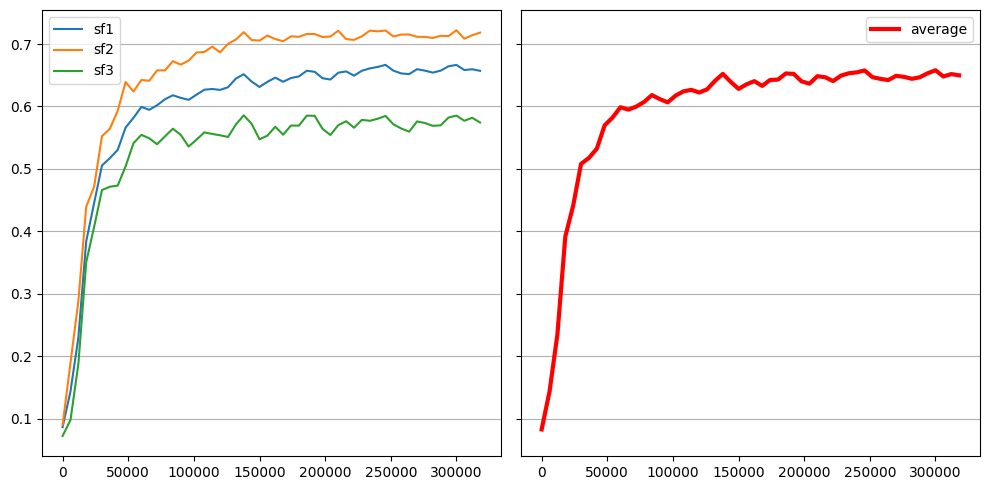

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5), sharex = True, sharey=True)

ax1.grid(axis='y')
ax1.plot(arraystep, arraysp1, label = "sf1")
ax1.plot(arraystep, arraysp2, label = "sf2")
ax1.plot(arraystep, arraysp3, label = "sf3")
ax1.legend()

ax2.grid(axis='y')
ax2.plot(arraystep, array_avg, color = "red", label = "average", lw = 3.0)
ax2.legend()

fig.tight_layout()
fig.show()

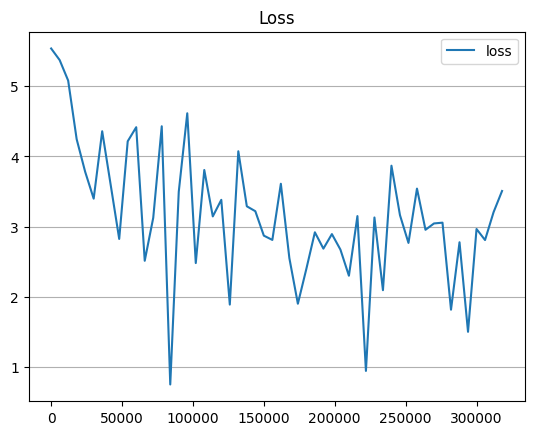

In [ ]:
plt.plot(arraystep, arrayloss, label = "loss")
plt.legend()
plt.title("Loss")
plt.grid(axis='y')
plt.show()

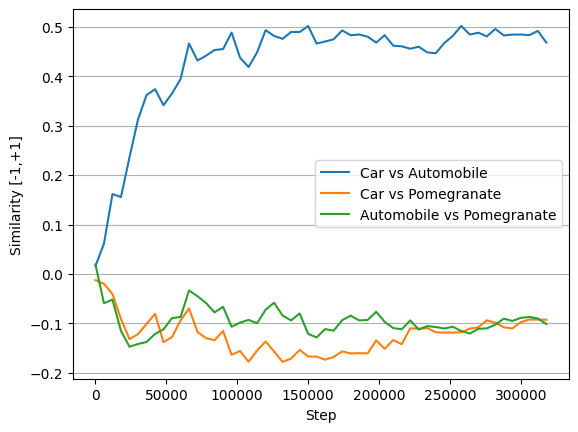

In [ ]:
line1 = [cosine_similarity(x, emb_automobile[idx]) for idx, x in enumerate(emb_car)]
line2 = [cosine_similarity(x, emb_pomegranate[idx]) for idx, x in enumerate(emb_car)]
line3 = [cosine_similarity(x, emb_pomegranate[idx]) for idx, x in enumerate(emb_automobile)]

plt.plot(arraystep, line1, label = "Car vs Automobile")
plt.plot(arraystep, line2, label = "Car vs Pomegranate")
plt.plot(arraystep, line3, label = "Automobile vs Pomegranate")

plt.xlabel("Step")
plt.ylabel("Similarity [-1,+1]")
plt.legend()
plt.grid(axis='y')
plt.show()

# What if we combine target and context embeddings?

In [ ]:
trg_embeddings = model.input_embeddings()
s1, s2, s3, av = get_scores(trg_embeddings)

In [ ]:
print("For target embeddings:")
print("[SP1: %.3f] [SP2: %.3f] [SP3: %.3f] [AVG: %.3f]" % (s1, s2, s3, av))

For target embeddings:
[SP1: 0.657] [SP2: 0.711] [SP3: 0.579] [AVG: 0.649]


In [ ]:
ctx_embeddings = model.output_embeddings()
s1, s2, s3, av = get_scores(ctx_embeddings)

In [ ]:
print("For context embeddings:")
print("[SP1: %.3f] [SP2: %.3f] [SP3: %.3f] [AVG: %.3f]" % (s1, s2, s3, av))

For context embeddings:
[SP1: 0.323] [SP2: 0.333] [SP3: 0.305] [AVG: 0.320]


In [ ]:
combined_embeddings = (trg_embeddings + ctx_embeddings) / 2.0
s1, s2, s3, av = get_scores(combined_embeddings)

In [ ]:
print("For combined embeddings:")
print("[SP1: %.3f] [SP2: %.3f] [SP3: %.3f] [AVG: %.3f]" % (s1, s2, s3, av))

For combined embeddings:
[SP1: 0.578] [SP2: 0.636] [SP3: 0.436] [AVG: 0.550]


# Closest neighbors

## For target or context emmbeddings

In [ ]:
def neighbors_from_word(word, word_to_embeddings, return_scores = False, topk = 10):

  neighbor_words = ["<NULL>"] * topk
  neighbor_similarities = [-1.0] * topk
  min_neighbor = neighbor_similarities.index(min(neighbor_similarities))

  if word not in list(word_to_embeddings.keys()):
    return neighbor_words, neighbor_similarities

  input_emb = word_to_embeddings[word]

  for w in word_to_embeddings.keys():
    word_emb = word_to_embeddings[w]
    sim = cosine_similarity(input_emb, word_emb)

    if sim >= neighbor_similarities[min_neighbor]:
      neighbor_similarities[min_neighbor] = sim
      neighbor_words[min_neighbor] = w
      min_neighbor = neighbor_similarities.index(min(neighbor_similarities))

  if return_scores:
    return neighbor_words, neighbor_similarities
  else:
    return neighbor_words


In [ ]:
test_words = ["car", "money", "flower", "japan"]

table = PrettyTable()
for w in test_words:
  table.add_column("'%s' (target)" % (w) , neighbors_from_word(w, final_embeddings_target))
  table.add_column("'%s' (context)" % (w) , neighbors_from_word(w, final_embeddings_context))

print(table)

+----------------+-----------------+------------------+-------------------+-------------------+--------------------+------------------+-------------------+
| 'car' (target) | 'car' (context) | 'money' (target) | 'money' (context) | 'flower' (target) | 'flower' (context) | 'japan' (target) | 'japan' (context) |
+----------------+-----------------+------------------+-------------------+-------------------+--------------------+------------------+-------------------+
|     driver     |     minivans    |    depositors    |        rand       |     coriander     |       komodo       |     japanese     |     kagoshima     |
|      car       |      akbar      |    securities    |     arbitrage     |       scent       |        bees        |     malaysia     |       china       |
|      suv       |       cars      |     expenses     |        tus        |      flowers      |       hawai        |      china       |        tojo       |
|    chassis     |     brabham     |      taxes       |       bi

## For combined embeddings

In [ ]:
def neighbors_from_word_2emb(word, word_to_embeddings1, word_to_embeddings2, return_scores = False, topk = 10):

  neighbor_words = ["<NULL>"] * topk
  neighbor_similarities = [-1.0] * topk
  min_neighbor = neighbor_similarities.index(min(neighbor_similarities))

  if (word not in list(word_to_embeddings1.keys())) or (word not in list(word_to_embeddings2.keys())):
    return neighbor_words, neighbor_similarities

  input_emb = (word_to_embeddings1[word] / 2) + (word_to_embeddings2[word] / 2)

  for w in word_to_embeddings1.keys():
    word_emb = (word_to_embeddings1[w] / 2) + (word_to_embeddings2[w] / 2)
    sim = cosine_similarity(input_emb, word_emb)

    if sim >= neighbor_similarities[min_neighbor]:
      neighbor_similarities[min_neighbor] = sim
      neighbor_words[min_neighbor] = w
      min_neighbor = neighbor_similarities.index(min(neighbor_similarities))

  if return_scores:
    return neighbor_words, neighbor_similarities
  else:
    return neighbor_words

In [ ]:
test_words = ["car", "money", "flower", "japan", "suspicious"]

table = PrettyTable()
for w in test_words:
  data = neighbors_from_word_2emb(w, final_embeddings_target, final_embeddings_context)
  table.add_column("'%s' (t+c)" % (w) , data)

print(table)

# Disconnect from runtime

In [ ]:
from google.colab import runtime
runtime.unassign()